In [10]:
import IPython
import librosa.display 
import librosa 
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, cross_val_score

sr = 44100

In [5]:
listA = glob.glob('*mobi.WAV')
wav_listA = sorted(listA) #globはぐちゃぐちゃなので並べる
print(wav_listA)

['all_vaccum_mobi.WAV', 'all_walk_mobi.WAV', 'bed_sleep_mobi.WAV', 'kit_cooking_mobi.WAV', 'kit_gas_mobi.WAV', 'kit_meal_mobi.WAV', 'kit_wash2_mobi.WAV', 'kit_wash_mobi.WAV', 'kit_wave_mobi.WAV', 'liv_TV_mobi.WAV', 'liv_voice_mobi.WAV']


In [6]:
len(listA)

11

In [37]:
mobi_list = [i for i in range(11)]
for i in range(11):
    mobi_list[i], sr = librosa.load(wav_listA[i], sr=44100)

In [40]:
mobi_list[0]

array([ 1.09908906e-04,  4.99710150e-04,  1.20245444e-03, ...,
       -3.44574764e-05, -5.41775535e-06,  0.00000000e+00], dtype=float32)

In [41]:
#全体の長さはバラバラで良い
def arangeList2(a_list, cut_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    #for j in range(len(b_list)):
    #    c_list[j] = b_list[j][:total_time*sampling_rate] #全体をtotal_time秒にする
        
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [46]:
aranged = arangeList2(mobi_list, 5, 4, sr)
for i in range(11):
    print(len(aranged[i]))

13
35
289
72
132
179
159
62
91
29
67


In [ ]:
def makeTokucho_with(a_list):
    tokucho1 = [] 
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
            tokucho_librosa = [np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
            
            for e in mfcc:
                MFCC = np.mean(e)
                tokucho_librosa.append(MFCC)
            #tokucho_librosa.append(i % 3) #部屋
            tokucho_librosa.append(0) #正解ラベル
            #tokucho_librosa.append(0) #人
            
            tokucho1.append(tokucho_librosa) 
           
            
    
    return tokucho1

In [54]:
feature = makeTokucho_with(aranged)

In [55]:
header = 'spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}' #ヘッダーにmfcc(1~20)の番号をつける
header += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header = header.split() #区切り文字で分割する
header
#header = np.array(header)

['spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [73]:
df = pd.DataFrame(feature)
df.columns = header
df

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,5903.966684,5029.763704,11689.283713,0.131414,-168.494324,52.856651,-38.849758,-0.097841,-24.889736,3.753376,...,-0.959542,6.478684,12.419890,-1.144690,-0.770497,-4.351382,3.070772,-1.399104,10.210115,0
1,6024.592951,5180.615782,11995.492103,0.162851,-126.346878,49.778599,-33.522690,8.943544,-16.357368,2.053432,...,4.828958,10.904580,14.444787,5.036570,2.902881,3.233542,7.466596,1.433386,10.499679,0
2,6349.221095,5193.504081,12379.656929,0.194043,-174.755539,52.056076,-31.188406,3.030263,-18.922844,7.424530,...,5.410363,8.404778,11.671843,5.519427,-0.459632,1.309136,7.308202,2.012633,11.150456,0
3,6060.849414,5086.933553,12101.160836,0.180966,-168.503983,58.865128,-31.479961,5.376022,-20.152966,8.044039,...,2.680539,7.144142,11.160797,0.849053,-2.873553,0.964295,6.861410,0.114741,10.812188,0
4,6328.722632,5184.263748,12442.321671,0.201165,-159.091904,56.361629,-27.202530,5.452022,-20.900761,6.536431,...,3.259337,7.035286,10.073166,-0.489744,-0.993456,0.113157,5.221022,1.078674,9.845431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,2414.336140,3538.859597,4677.198964,0.039031,-518.318115,151.783401,-6.768327,24.410801,24.097820,16.415514,...,5.297174,-6.126787,-1.041504,1.769140,-2.283012,-1.590110,6.428540,1.045464,3.237622,0
1124,2555.025826,3409.353133,4921.616423,0.050174,-493.910156,152.468903,-15.269933,25.306555,19.200979,19.038883,...,6.655221,-9.332224,-2.912066,3.365330,-0.908372,-2.959122,7.337487,2.363528,-0.117547,0
1125,2306.724012,3297.614603,4178.689708,0.039276,-493.705811,157.134705,-14.804039,24.756104,23.583637,19.046801,...,4.925375,-9.930328,-4.670947,1.958920,-1.490071,-3.400308,4.300107,-0.344510,-0.091875,0
1126,2691.498614,3464.070182,5131.081437,0.057403,-489.909515,148.769516,-17.584602,23.350574,18.058899,17.732981,...,4.173254,-8.412276,-1.432734,3.258248,-1.754619,-2.746814,6.839493,0.773410,2.734786,0


In [155]:

len_all = len(aranged[0])+len(aranged[1])
len_liv = len(aranged[9])+len(aranged[10])
len_kit = len(aranged[3])+len(aranged[4])+len(aranged[5])+len(aranged[6])+len(aranged[7])+len(aranged[8])
len_bed = len(aranged[2])

df.iloc[:len_all, 24:] = 3
df.iloc[len_all:len_all+len_bed, 24:] = 2
df.iloc[len_all+len_bed:len_all+len_bed+len_kit, 24:] = 1
df.iloc[len_all+len_bed+len_kit:len_all+len_bed+len_kit+len_liv, 24:] = 0
df

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,5903.966684,5029.763704,11689.283713,0.131414,-168.494324,52.856651,-38.849758,-0.097841,-24.889736,3.753376,...,-0.959542,6.478684,12.419890,-1.144690,-0.770497,-4.351382,3.070772,-1.399104,10.210115,3
1,6024.592951,5180.615782,11995.492103,0.162851,-126.346878,49.778599,-33.522690,8.943544,-16.357368,2.053432,...,4.828958,10.904580,14.444787,5.036570,2.902881,3.233542,7.466596,1.433386,10.499679,3
2,6349.221095,5193.504081,12379.656929,0.194043,-174.755539,52.056076,-31.188406,3.030263,-18.922844,7.424530,...,5.410363,8.404778,11.671843,5.519427,-0.459632,1.309136,7.308202,2.012633,11.150456,3
3,6060.849414,5086.933553,12101.160836,0.180966,-168.503983,58.865128,-31.479961,5.376022,-20.152966,8.044039,...,2.680539,7.144142,11.160797,0.849053,-2.873553,0.964295,6.861410,0.114741,10.812188,3
4,6328.722632,5184.263748,12442.321671,0.201165,-159.091904,56.361629,-27.202530,5.452022,-20.900761,6.536431,...,3.259337,7.035286,10.073166,-0.489744,-0.993456,0.113157,5.221022,1.078674,9.845431,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,2414.336140,3538.859597,4677.198964,0.039031,-518.318115,151.783401,-6.768327,24.410801,24.097820,16.415514,...,5.297174,-6.126787,-1.041504,1.769140,-2.283012,-1.590110,6.428540,1.045464,3.237622,0
1124,2555.025826,3409.353133,4921.616423,0.050174,-493.910156,152.468903,-15.269933,25.306555,19.200979,19.038883,...,6.655221,-9.332224,-2.912066,3.365330,-0.908372,-2.959122,7.337487,2.363528,-0.117547,0
1125,2306.724012,3297.614603,4178.689708,0.039276,-493.705811,157.134705,-14.804039,24.756104,23.583637,19.046801,...,4.925375,-9.930328,-4.670947,1.958920,-1.490071,-3.400308,4.300107,-0.344510,-0.091875,0
1126,2691.498614,3464.070182,5131.081437,0.057403,-489.909515,148.769516,-17.584602,23.350574,18.058899,17.732981,...,4.173254,-8.412276,-1.432734,3.258248,-1.754619,-2.746814,6.839493,0.773410,2.734786,0


In [156]:
print(len(df[df["label"]==1]))
print(len(df[df["label"]==2]))
print(len(df[df["label"]==3]))
print(len(df[df["label"]==4]))
print(len(df[df["label"]==0]))

695
289
48
0
96


In [157]:
def kondo1(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)

#最初
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)


    from sklearn.metrics import classification_report
    
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo2(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)


#いじる
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    #plt.savefig('seaborn_heatmap_bedroom_2.pdf',bbox_inches='tight')

In [158]:
# 特徴量の標準化
def StandardSplit(df, test_size, rondom):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(df.iloc[:, :-1], dtype = float))
    y = df["label"]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,random_state=rondom)
    print('trainは'+str(len(y_train)))
    print('testは'+str(len(y_test)))
    
    return X, y, X_train, X_test, y_train, y_test

In [159]:
X, y, X_train, X_test, y_train, y_test = StandardSplit(df, 0.3, 77)

trainは789
testは339


In [160]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 1.00


              precision    recall  f1-score   support

      living       1.00      1.00      1.00        29
     kitchen       1.00      1.00      1.00       209
     bedroom       1.00      1.00      1.00        87
       other       1.00      1.00      1.00        14

    accuracy                           1.00       339
   macro avg       1.00      1.00      1.00       339
weighted avg       1.00      1.00      1.00       339



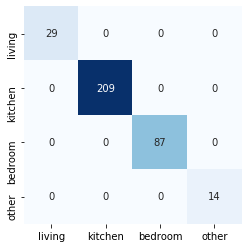

In [161]:
kondo1(X_test, y_test, model)

## とりあえずテストデータだけでは大丈夫

## 試しに卒論のデータで検証

In [105]:
g_listA = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/a*.wav')
wav_listA = sorted(g_listA) #globはぐちゃぐちゃなので並べる
print(wav_listA)

['/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_01.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_02.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_03.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_04.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_05.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_06.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_07.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_08.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_09.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_10.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_11.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_12.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_13.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_14.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/arita_15.wav', '/Users/tomokijoya/Labol

In [106]:
from tqdm import tqdm

Alist = [i for i in range(21)]
for i in tqdm(range(21)):
    Alist[i], sr = librosa.load(wav_listA[i], sr=44100)

100%|██████████| 21/21 [00:00<00:00, 27.72it/s]


In [107]:
g_listT = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/t*.wav')
wav_listT = sorted(g_listT) #globはぐちゃぐちゃなので並べる
print(wav_listT)

['/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_01.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_02.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_03.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_04.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_05.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_06.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_07.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_08.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_09.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_10.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_11.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_12.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_13.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_14.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/toku_15.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/

In [109]:
from tqdm import tqdm

Tlist = [i for i in range(21)]
for i in tqdm(range(21)):
    Tlist[i], sr = librosa.load(wav_listT[i], sr=44100)

100%|██████████| 21/21 [00:00<00:00, 34.68it/s]


In [110]:
g_listJ = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/j*.wav')
wav_listJ = sorted(g_listJ) #globはぐちゃぐちゃなので並べる
print(wav_listJ)

['/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_01.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_02.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_03.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_04.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_05.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_06.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_07.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_08.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_09.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_10.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_11.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_12.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_13.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_14.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/joya_15.wav', '/Users/tomokijoya/Labolatory/卒論/卒論データ/

In [112]:
from tqdm import tqdm

Jlist = [i for i in range(21)]
for i in tqdm(range(21)):
    Jlist[i], sr = librosa.load(wav_listJ[i], sr=44100)

100%|██████████| 21/21 [00:00<00:00, 30.30it/s]


In [116]:
def makeTokucho_sotsuron(a_list):
    tokucho1 = [] 
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
            tokucho_librosa = [np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
            
            for e in mfcc:
                MFCC = np.mean(e)
                tokucho_librosa.append(MFCC)
            tokucho_librosa.append(i % 3) #部屋
            tokucho_librosa.append(0) #正解ラベル
            tokucho_librosa.append(0) #人
            
            tokucho1.append(tokucho_librosa)            
            
    
    return tokucho1

In [114]:
arangedA = arangeList(Alist, 0, 120, 4, sr)
arangedT = arangeList(Tlist, 0, 120, 4, sr)
arangedJ = arangeList(Jlist, 5, 120, 4, sr)

In [117]:
A_feature = makeTokucho_sotsuron(arangedA)
T_feature = makeTokucho_sotsuron(arangedT)
J_feature = makeTokucho_sotsuron(arangedJ)

In [119]:
header_S = 'spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header_S += f' mfcc{i}' #ヘッダーにmfcc(1~20)の番号をつける
header_S += ' room label name'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header_S = header_S.split() #区切り文字で分割する
header_S
#header = np.array(header)

['spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'room',
 'label',
 'name']

In [137]:
df_A = pd.DataFrame(A_feature)
df_T = pd.DataFrame(T_feature)
df_J = pd.DataFrame(J_feature)

df_A.columns = header_S
df_T.columns = header_S
df_J.columns = header_S
df_A

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,room,label,name
0,5464.967594,6099.656927,12993.009935,0.095400,-530.786072,84.157295,2.115900,15.866791,9.071639,-2.461344,...,1.970870,7.245992,8.384298,4.286462,4.800427,4.245162,2.315230,0,0,0
1,5206.366257,5907.608514,12133.117357,0.090832,-524.063049,85.637375,-1.822779,13.522172,5.085418,-4.276443,...,1.653701,7.057560,10.546593,5.579610,1.631155,0.571133,2.216148,0,0,0
2,6193.536632,6695.895693,15188.710088,0.091280,-563.358948,74.323944,21.500042,18.988716,12.859176,6.443839,...,0.447312,4.702463,6.531244,2.235013,4.296216,4.642476,3.293868,0,0,0
3,5633.598646,6363.310976,13744.986838,0.084420,-546.568665,84.028236,17.662041,16.462273,6.103097,-0.700799,...,3.096126,7.269464,7.286633,3.551577,5.540136,4.493495,2.034727,0,0,0
4,5870.099503,6482.937759,14289.496009,0.090021,-553.132080,78.314560,18.116823,19.725405,9.399602,-0.358914,...,2.016120,6.066536,6.699254,3.518159,5.200072,4.396051,2.374561,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,7344.044863,7182.246797,16900.318869,0.108807,-605.661804,54.877151,36.905014,26.993048,19.447390,15.772990,...,1.703163,1.233357,2.095792,0.008857,1.358643,1.461225,0.888396,2,0,0
626,7393.002446,7176.973885,16934.647164,0.112980,-605.882507,54.366180,36.534756,27.304453,19.589685,15.711556,...,1.956484,1.529058,2.201263,0.197668,1.178341,1.437460,1.212828,2,0,0
627,7373.969176,7177.411181,16908.183169,0.110299,-605.350525,54.832745,36.705700,26.548010,19.061024,15.706324,...,1.484764,0.938313,2.012413,-0.144899,0.604293,0.829875,0.413761,2,0,0
628,7395.409169,7173.194747,16924.785581,0.113113,-605.671631,54.746376,37.248531,27.358950,19.046532,15.716253,...,1.922140,1.376204,1.793313,-0.259570,1.120625,1.566903,1.485225,2,0,0


In [138]:
#行動のラベル
df_A.iloc[0:90*2,-2] = int(0)
df_A.iloc[90*2:90*5,-2] = int(1)
df_A.iloc[90*5:90*7,-2] = int(2)

df_T.iloc[0:90*2,-2] = int(0)
df_T.iloc[90*2:90*5,-2] = int(1)
df_T.iloc[90*5:90*7,-2] = int(2)

df_J.iloc[0:90*2,-2] = int(0)
df_J.iloc[90*2:90*5,-2] = int(1)
df_J.iloc[90*5:90*7,-2] = int(2)

#人の名前
df_A.iloc[:,-1] = int(7)
df_T.iloc[:,-1] = int(8)
df_J.iloc[:,-1] = int(9)
df_A

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,room,label,name
0,5464.967594,6099.656927,12993.009935,0.095400,-530.786072,84.157295,2.115900,15.866791,9.071639,-2.461344,...,1.970870,7.245992,8.384298,4.286462,4.800427,4.245162,2.315230,0,0,7
1,5206.366257,5907.608514,12133.117357,0.090832,-524.063049,85.637375,-1.822779,13.522172,5.085418,-4.276443,...,1.653701,7.057560,10.546593,5.579610,1.631155,0.571133,2.216148,0,0,7
2,6193.536632,6695.895693,15188.710088,0.091280,-563.358948,74.323944,21.500042,18.988716,12.859176,6.443839,...,0.447312,4.702463,6.531244,2.235013,4.296216,4.642476,3.293868,0,0,7
3,5633.598646,6363.310976,13744.986838,0.084420,-546.568665,84.028236,17.662041,16.462273,6.103097,-0.700799,...,3.096126,7.269464,7.286633,3.551577,5.540136,4.493495,2.034727,0,0,7
4,5870.099503,6482.937759,14289.496009,0.090021,-553.132080,78.314560,18.116823,19.725405,9.399602,-0.358914,...,2.016120,6.066536,6.699254,3.518159,5.200072,4.396051,2.374561,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,7344.044863,7182.246797,16900.318869,0.108807,-605.661804,54.877151,36.905014,26.993048,19.447390,15.772990,...,1.703163,1.233357,2.095792,0.008857,1.358643,1.461225,0.888396,2,2,7
626,7393.002446,7176.973885,16934.647164,0.112980,-605.882507,54.366180,36.534756,27.304453,19.589685,15.711556,...,1.956484,1.529058,2.201263,0.197668,1.178341,1.437460,1.212828,2,2,7
627,7373.969176,7177.411181,16908.183169,0.110299,-605.350525,54.832745,36.705700,26.548010,19.061024,15.706324,...,1.484764,0.938313,2.012413,-0.144899,0.604293,0.829875,0.413761,2,2,7
628,7395.409169,7173.194747,16924.785581,0.113113,-605.671631,54.746376,37.248531,27.358950,19.046532,15.716253,...,1.922140,1.376204,1.793313,-0.259570,1.120625,1.566903,1.485225,2,2,7


In [139]:
df_A = df_A[df_A["room"] == df_A["label"]]
df_T = df_T[df_T["room"] == df_T["label"]]
df_J = df_J[df_J["room"] == df_J["label"]]
df_A

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,room,label,name
0,5464.967594,6099.656927,12993.009935,0.095400,-530.786072,84.157295,2.115900,15.866791,9.071639,-2.461344,...,1.970870,7.245992,8.384298,4.286462,4.800427,4.245162,2.315230,0,0,7
1,5206.366257,5907.608514,12133.117357,0.090832,-524.063049,85.637375,-1.822779,13.522172,5.085418,-4.276443,...,1.653701,7.057560,10.546593,5.579610,1.631155,0.571133,2.216148,0,0,7
2,6193.536632,6695.895693,15188.710088,0.091280,-563.358948,74.323944,21.500042,18.988716,12.859176,6.443839,...,0.447312,4.702463,6.531244,2.235013,4.296216,4.642476,3.293868,0,0,7
3,5633.598646,6363.310976,13744.986838,0.084420,-546.568665,84.028236,17.662041,16.462273,6.103097,-0.700799,...,3.096126,7.269464,7.286633,3.551577,5.540136,4.493495,2.034727,0,0,7
4,5870.099503,6482.937759,14289.496009,0.090021,-553.132080,78.314560,18.116823,19.725405,9.399602,-0.358914,...,2.016120,6.066536,6.699254,3.518159,5.200072,4.396051,2.374561,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,7344.044863,7182.246797,16900.318869,0.108807,-605.661804,54.877151,36.905014,26.993048,19.447390,15.772990,...,1.703163,1.233357,2.095792,0.008857,1.358643,1.461225,0.888396,2,2,7
626,7393.002446,7176.973885,16934.647164,0.112980,-605.882507,54.366180,36.534756,27.304453,19.589685,15.711556,...,1.956484,1.529058,2.201263,0.197668,1.178341,1.437460,1.212828,2,2,7
627,7373.969176,7177.411181,16908.183169,0.110299,-605.350525,54.832745,36.705700,26.548010,19.061024,15.706324,...,1.484764,0.938313,2.012413,-0.144899,0.604293,0.829875,0.413761,2,2,7
628,7395.409169,7173.194747,16924.785581,0.113113,-605.671631,54.746376,37.248531,27.358950,19.046532,15.716253,...,1.922140,1.376204,1.793313,-0.259570,1.120625,1.566903,1.485225,2,2,7


In [150]:
df_ATJ = pd.concat([df_A, df_T, df_J])
df_ATJ = df_ATJ.drop("room", axis=1)
df_ATJ

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,name
0,5464.967594,6099.656927,12993.009935,0.095400,-530.786072,84.157295,2.115900,15.866791,9.071639,-2.461344,...,0.592092,1.970870,7.245992,8.384298,4.286462,4.800427,4.245162,2.315230,0,7
1,5206.366257,5907.608514,12133.117357,0.090832,-524.063049,85.637375,-1.822779,13.522172,5.085418,-4.276443,...,2.913130,1.653701,7.057560,10.546593,5.579610,1.631155,0.571133,2.216148,0,7
2,6193.536632,6695.895693,15188.710088,0.091280,-563.358948,74.323944,21.500042,18.988716,12.859176,6.443839,...,3.074027,0.447312,4.702463,6.531244,2.235013,4.296216,4.642476,3.293868,0,7
3,5633.598646,6363.310976,13744.986838,0.084420,-546.568665,84.028236,17.662041,16.462273,6.103097,-0.700799,...,2.388919,3.096126,7.269464,7.286633,3.551577,5.540136,4.493495,2.034727,0,7
4,5870.099503,6482.937759,14289.496009,0.090021,-553.132080,78.314560,18.116823,19.725405,9.399602,-0.358914,...,2.216563,2.016120,6.066536,6.699254,3.518159,5.200072,4.396051,2.374561,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,7286.623635,7163.516176,16814.435717,0.102914,-605.317383,55.048782,36.307228,26.953077,19.357634,15.780226,...,3.799234,2.131720,1.926745,2.088810,0.207484,2.083856,2.376844,1.866301,2,9
626,7368.514192,7168.569950,16881.719175,0.108608,-606.083435,54.481647,35.717651,26.649910,19.508127,15.654320,...,3.206995,1.428769,1.765144,2.468622,0.987050,1.993293,1.854782,1.759308,2,9
627,7405.828208,7170.190774,16908.495245,0.113225,-606.024048,54.435532,36.024094,26.956966,19.788765,15.974608,...,3.599650,2.029729,1.977658,1.919900,1.245108,2.317795,1.982779,2.206123,2,9
628,7417.653437,7167.339307,16923.037959,0.115093,-605.985229,54.795181,36.652107,27.144308,19.485634,15.595446,...,3.560127,2.132763,1.342369,1.888926,0.715315,2.443805,2.327326,2.407313,2,9


# ここから検証

## モデルの作成

In [163]:
df

,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,5903.966684,5029.763704,11689.283713,0.131414,-168.494324,52.856651,-38.849758,-0.097841,-24.889736,3.753376,...,-0.959542,6.478684,12.419890,-1.144690,-0.770497,-4.351382,3.070772,-1.399104,10.210115,3
1,6024.592951,5180.615782,11995.492103,0.162851,-126.346878,49.778599,-33.522690,8.943544,-16.357368,2.053432,...,4.828958,10.904580,14.444787,5.036570,2.902881,3.233542,7.466596,1.433386,10.499679,3
2,6349.221095,5193.504081,12379.656929,0.194043,-174.755539,52.056076,-31.188406,3.030263,-18.922844,7.424530,...,5.410363,8.404778,11.671843,5.519427,-0.459632,1.309136,7.308202,2.012633,11.150456,3
3,6060.849414,5086.933553,12101.160836,0.180966,-168.503983,58.865128,-31.479961,5.376022,-20.152966,8.044039,...,2.680539,7.144142,11.160797,0.849053,-2.873553,0.964295,6.861410,0.114741,10.812188,3
4,6328.722632,5184.263748,12442.321671,0.201165,-159.091904,56.361629,-27.202530,5.452022,-20.900761,6.536431,...,3.259337,7.035286,10.073166,-0.489744,-0.993456,0.113157,5.221022,1.078674,9.845431,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,2414.336140,3538.859597,4677.198964,0.039031,-518.318115,151.783401,-6.768327,24.410801,24.097820,16.415514,...,5.297174,-6.126787,-1.041504,1.769140,-2.283012,-1.590110,6.428540,1.045464,3.237622,0
1124,2555.025826,3409.353133,4921.616423,0.050174,-493.910156,152.468903,-15.269933,25.306555,19.200979,19.038883,...,6.655221,-9.332224,-2.912066,3.365330,-0.908372,-2.959122,7.337487,2.363528,-0.117547,0
1125,2306.724012,3297.614603,4178.689708,0.039276,-493.705811,157.134705,-14.804039,24.756104,23.583637,19.046801,...,4.925375,-9.930328,-4.670947,1.958920,-1.490071,-3.400308,4.300107,-0.344510,-0.091875,0
1126,2691.498614,3464.070182,5131.081437,0.057403,-489.909515,148.769516,-17.584602,23.350574,18.058899,17.732981,...,4.173254,-8.412276,-1.432734,3.258248,-1.754619,-2.746814,6.839493,0.773410,2.734786,0


In [164]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-1], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ.iloc[:, :-2], dtype = float))
y_test = df_ATJ["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは1128
trainyは1128
testXは630
testyは630


In [165]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.67


              precision    recall  f1-score   support

      living       0.33      0.10      0.15       180
     kitchen       0.61      0.86      0.72       270
     bedroom       0.87      0.95      0.91       180
       other       0.00      0.00      0.00         0

    accuracy                           0.67       630
   macro avg       0.45      0.48      0.44       630
weighted avg       0.61      0.67      0.61       630



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


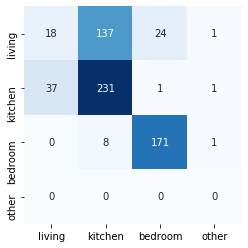

In [166]:
kondo1(X_test, y_test, model)

In [171]:
y_train.value_counts()

1    695
2    289
0     96
3     48
Name: label, dtype: int64